# Stack Development

We know that L = 4 reconstructs well with ternary r and predicted inputs.

The VPUWrapper is similar to our original stage - we now need to merge these.

We can start with audio data - 256 is a power of 4.

In [1]:
import numpy as np
import math

In [2]:
256**(1/4)

4.0

In [3]:
math.log(256, 4)

4.0

In [43]:
from src.var_processor.vpu import VPUBinaryZM

class Stage:
    """Object to represent a stage of processing."""

    def __init__(self, vec_len, stage_len):
        """Initialise stage.

        Arg:
            vec_len - length of each 1D vector processed by the VPUs.
            stage_len - integer indicating number of VPUs.
        """
        self.vec_len = vec_len
        self.stage_len = stage_len
        self.size = self.vec_len*self.stage_len
        self.vpus = [VPUBinaryZM(vec_len) for _ in range(0, stage_len)]
        # Create a blank array for the causes
        self.causes = np.zeros(shape=(stage_len, 1))
        # Create a blank array for the predicted inputs
        self.pred_inputs = np.zeros(shape=(self.size, 1))
        # Helper data to keep indices
        self.ranges = [range(i*vec_len, (i+1)*vec_len) for i in range(0, stage_len)]
        
    def forward(self, forward_data):
        """Forward pass through the stage (excludes cov update).
        
        Args:
            input_signal - 1D numpy array of length size.
        Returns:
            r - 1D numpy array of causes.
        """
        for i, vpu in enumerate(self.vpus):
            forward_segment = forward_data[self.ranges[i]]
            self.causes[i] = vpu.forward(forward_segment)
        return self.get_causes()
    
    def backward(self, r_backward):
        """Backward pass through the stage.
        
        Args:
            r_backward - 1D numpy array of causes of stage_len.
        Returns:
            pred_inputs - 1D numpy array of length size of predicted inputs.
        """
        for i, vpu in enumerate(self.vpus):
            feedback_segment = r_backward[i]
            self.pred_inputs[self.ranges[i]] = vpu.backward(feedback_segment)
        return self.get_pred_inputs()
    
    def update_cov(self, input_data, power_iterate=True):
        """Update covariance data.
        
        Args:
            input_data: 1D numpy array of length size.
        """
        for i, vpu in enumerate(self.vpus):
            input_segment = input_data[self.ranges[i]]
            vpu.update_cov(input_segment, power_iterate=power_iterate)

    def iterate(self, stage_in, residual_in, stage_feedback):
        """Pass data to the stage for processing.

        Arg:
            stage_in - 1D numpy array with data to process.
            residual_in - 1D numpy array with mix of predicted / original.
            stage_feedback - 1D numpy array with feedback data.

        Returns:
            r_out - 1D numpy array of causes.
            pred_input - 1D numpy array with predicted input.

        """
        self.update_cov(stage_in)
        causes = self.forward(residual_in)
        pred_inputs = self.backward(stage_feedback)
        return causes, pred_inputs

    def get_causes(self):
        """Return output of VPUs as array."""
        return self.causes.copy()

    def get_pred_inputs(self):
        """Return predicted inputs as array."""
        return self.pred_inputs.copy()

    def __repr__(self):
        """Print layer information."""
        string = f"There are {self.stage_len} units \n"
        string += f"with dimensionality {self.vec_len}x1"
        return string

In [60]:
from src.tests.vpu_wrapper import signal_pre_processor

# Testing a stage
size = 256
vec_len = 4
buf_length = 1000
stage = Stage(vec_len, size//vec_len)

# Generate fake data
data_in = np.random.randint(255, size=(size, 1))
mean = np.asarray([128]*size).reshape(-1, 1)

# Generate buffers for testing
input_buffer = np.zeros(shape=(size, buf_length))
pred_buffer = np.zeros(shape=(size, buf_length))
r_buffer = np.zeros(shape=(size//vec_len, buf_length))
residual_buffer = np.zeros(shape=(size, buf_length))  

for i in range(0, 1000):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    # Process stage
    stage.update_cov(data_in)
    causes = stage.forward(input_signal)
    pred_inputs = stage.backward(causes)
    input_buffer[:, i] = input_signal.ravel()
    pred_buffer[:, i] = pred_inputs.ravel()
    r_buffer[:, i] = causes.ravel()
    residual_buffer[:, i] = (input_signal - pred_inputs).ravel()

In [61]:
input_buffer[stage.ranges[10], 100]

array([ 1., -1.,  0.,  0.])

In [62]:
stage.vpus[0].pi.eigenvector

array([[0.60133255],
       [0.64726768],
       [0.45935125],
       [0.09187025]])

In [63]:
input_buffer.shape

(256, 1000)

In [64]:
input_signal.T

array([[ 0,  0,  0, -1,  0,  0,  1,  0, -1, -1, -1,  1, -1,  0,  1,  0,
         1, -1, -1,  0, -1, -1,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,
        -1,  1, -1, -1, -1,  0, -1,  0,  1, -1,  0,  0, -1,  0,  0,  1,
         0,  0,  0,  0, -1,  1, -1,  1,  0,  0,  0,  1,  0, -1, -1,  0,
         0,  1,  0,  0, -1,  1,  1, -1,  0,  0,  0,  0,  1,  1,  0,  1,
         0,  1,  0,  0, -1,  0,  1,  0, -1,  0,  0, -1,  1, -1,  1,  0,
         1,  0, -1,  0, -1,  1, -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,
         0,  0,  1, -1, -1,  0,  1, -1,  0,  0, -1,  1,  0, -1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,
         0,  1,  0,  0,  1,  0, -1, -1, -1,  0,  0,  1,  0,  0, -1,  0,
         1, -1,  0, -1,  0,  0, -1, -1, -1,  0,  1,  1, -1,  0, -1,  0,
         0,  1,  0,  0,  0,  0,  0, -1,  1,  1,  1,  0, -1,  0,  0,  0,
         1,  0, -1,  0,  0,  0,  1,  1,  0, -1,  1,  1, -1, -1,  1,  0,
         0,  0, -1,  1,  0,  1,  1, -1,  0,  0, -1,  1,  0,  0, 

In [65]:
causes.T

array([[-0.,  0.,  0.,  0.,  0., -0.,  1.,  1.,  0., -0.,  0.,  0.,  0.,
         0.,  1., -0.,  1.,  1.,  0.,  1.,  1.,  0., -0.,  0.,  0.,  0.,
        -0., -0.,  1.,  0.,  1.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        -0.,  0., -1.,  0., -0.,  0., -0.,  1., -0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [68]:
causes.sum()

17.0

In [69]:
r_buffer.sum()

14420.0

In [71]:
assert r_buffer.sum() < 256*500

In [76]:
(input_signal - pred_inputs).ravel()

array([ 0.,  0.,  0., -1.,  0.,  0.,  1.,  0., -1., -1., -1.,  1., -1.,
        0.,  1.,  0.,  1., -1., -1.,  0., -1., -1.,  0.,  0., -1.,  0.,
       -1.,  0.,  0., -1.,  0.,  0., -1.,  1., -1., -1., -1.,  0., -1.,
        0.,  1., -1.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
       -1.,  1., -1.,  1., -1., -1., -1.,  0.,  0., -1., -1.,  0.,  0.,
        0.,  0., -1., -1.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0., -1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  0.,
       -1.,  1., -1.,  1.,  0.,  1.,  0., -1.,  0., -1.,  1., -1., -1.,
        0.,  0.,  0., -1., -1.,  0., -1.,  0., -1., -1.,  0., -1., -1.,
        0.,  1., -1., -1., -1., -1.,  0.,  0., -1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0., -1.,
        0.,  0.,  1.,  0.,  0.,  1.,  0., -1., -1., -1.,  0.,  0.,  1.,
        0.,  0., -1.,  0.,  1., -1.,  0., -1.,  1.,  1.,  0.,  0., -1.,
        0.,  1.,  1., -1.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0

<IPython.core.display.Javascript object>


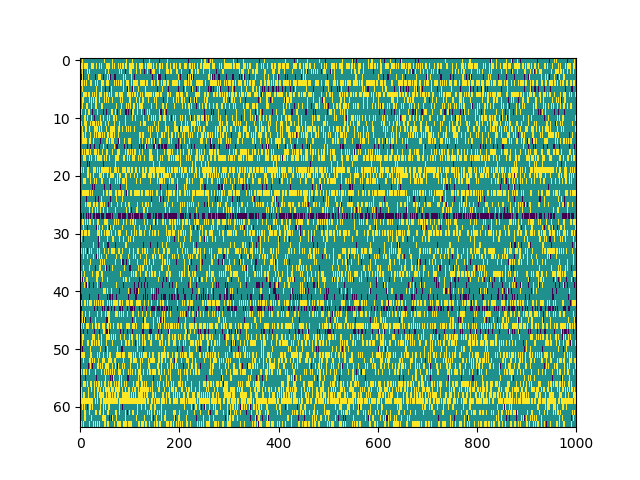

In [66]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.imshow(r_buffer, aspect='auto')

<IPython.core.display.Javascript object>


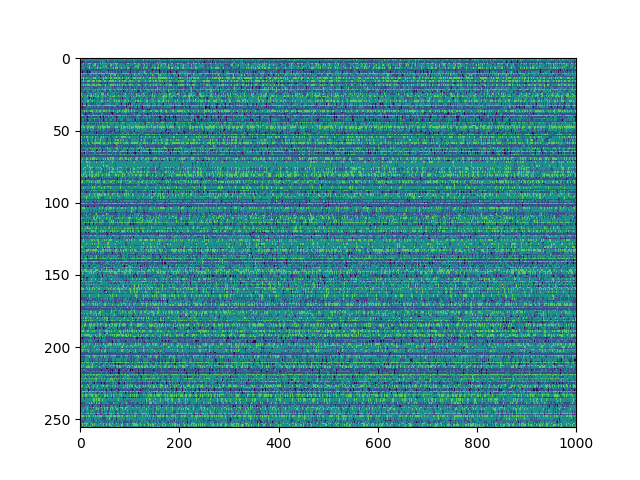

In [67]:
plt.imshow(residual_buffer, aspect='auto')

In [78]:
residual_buffer[:, 1].sum()

-50.0

In [ ]:
class Stack:
    """Object to process a 1D sensor signal."""

    def __init__(self, sensor_len, vec_len):
        """Initialise sensor.

        Arg:
            sensor_len - length of input sensor vector - needs to be
                a power of vec_len.
            vec_len - length of vector for VPU.
        """
        self.sensor_len = sensor_len
        self.vec_len = vec_len
        # self.time_len = time_len
        # Variable to store time stages
        self.stages = list()
        num_stages = math.log(self.sensor_len, self.vec_len)
        self.num_stages = int(num_stages)
        self.build_stages()

    def generate_stage(self, stage_len):
        """Generate a stage.

        Arg:
            stage_len - integer number of stages.
        """
        return Stage(self.vec_len, stage_len)

    def build_stages(self):
        """Build a set of stages."""
        self.stages = [
            self.generate_stage(
                int(self.sensor_len / self.vec_len**(i+1))
            )
            for i in range(0, self.num_stages)
        ]

    def forward(self, sw_residuals):
        """Forward pass through the stack.

        Args:
            sw_residuals: weighted residuals from switch, list of arrays.
        """
        pass

    def backward(self, stack_feedback):
        """Backward pass through the stack.

        Args:
            stack_feedback: feedback for last stage, scalar.
        """
        pass

    def update_cov(self, orig_input):
        """Update the covariance matrices.

        Run after computing the FF outputs in a forward pass.

        Args:
            orig_input: original un-switch-filtered input as array.
        """
        # for stage in stages:
        pass


    def iterate(self, orig_input, sw_residuals, stack_feedback):
        """High level processing loop.

        We have to implement the stack and switch together. The sw_residuals
        require output from the for loop below. The switch has a set
        of stages equal to the stack, each stage having a comparison
        and a weighting.

        Args:
            orig_input: original un-switch-filtered input, list of
                arrays.
            sw_residuals: weighted residuals from switch, list of arrays.
            stack_feedback: feedback for last stage, scalar.

        Returns:
            ff_outputs: FF outputs from each stage.
            predictions: FB outputs from each stage.

        """
        # How do we get current prediction when we haven't iterated?
        # Get prediction from last time stamp?
        # Or do a forward pass first, then do a backard pass?
        for i in range(0, self.num_stages-1):
            # Get predicted inputs for current stage
            prediction = self.stages[i].get_pred_inputs()
            # Compute FF input by adding residuals to prediction
            stage_ff_input = sw_residuals[i] + prediction
            # Get FB input from next stage
            stage_fb_input = self.stages[i+1].get_pred_inputs()
            # Iterate current FF stage
            feedforward, _ = self.stages[i].iterate(
                orig_inputs[i],
                stage_ff_input,
                stage_fb_input
            )
        # Then feedforward to last stage with stack_feedback
        feedforward, _ = self.stages[-1].iterate(
            orig_inputs[-1],
            feedforward,
            stack_feedback
        )
        # Return r_out for last stage
        return feedforward

    def get_causes(self):
        """Return causes as a list of arrays."""
        return [
            stage.get_causes() for stage in self.stages
        ]

    def get_pred_inputs(self):
        """Return predicted inputs as a list of arrays."""
        return [
            stage.get_pred_inputs() for stage in self.stages
        ]

    def get_outputs(self):
        """Return the outputs for the stack."""
        cause_output = self.stages[-1].get_causes()
        prediction_output = self.stages[0].get_pred_inputs()
        return cause_output, prediction_output

    def get_lengths(self):
        """Return the vector lengths of the causes and predicted inputs."""
        causes = self.get_causes()
        pred_inputs = self.get_pred_inputs()
        cause_lengths = [cause.shape[0] for cause in causes]
        pred_lengths = [pred.shape[0] for pred in pred_inputs]
        return cause_lengths, pred_lengths
